# RBA Selected Tables

Worth reading

*  [Updates to Australia's Financial Aggregates](https://www.rba.gov.au/publications/bulletin/2019/mar/updates-to-australias-financial-aggregates.html)

## Set-Up

In [1]:
# standard library imports
from pathlib import Path

# usual data science imports
import pandas as pd
import matplotlib.pyplot as plt

# local imports
import rba_data_capture
from abs_data_capture import (
    get_ABS_meta_and_data,
    get_fs_constants,
)
from plotting import (
    finalise_plot,
    set_chart_dir,
    clear_chart_dir,
    plot_series_highlighted,
    recalibrate_series,
    plot_covid_recovery,
)

### Some useful constants

In [2]:
TODAY = pd.Timestamp("today")
TOMORROW = TODAY + pd.DateOffset(days=1)

# multi-time-period charts
RECENCY_PERIOD_Y = 5  # years
RECENCY_PERIOD_M = 3  # months
RECENT = TODAY - pd.DateOffset(
    years=RECENCY_PERIOD_Y, months=RECENCY_PERIOD_M
)

V_RECENCY_PERIOD = 330  # days
V_RECENT = TODAY - pd.DateOffset(days=V_RECENCY_PERIOD)

TEN_YEARS = TODAY - pd.DateOffset(years=10)

# Where to put the charts
CHART_DIR = "./charts/RBA"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

# plotting stuff
plt.style.use("fivethirtyeight")
SOURCE = "Source: RBA"

### List available data tables - but only if needed

In [3]:
if False:
    print(rba_data_capture.get_data_table_labels())

### Clear cache - but only if necessary

In [4]:
if False:
    rba_data_capture.clear_cache()

### Utility functions

In [5]:
def print_last_date(df: pd.DataFrame) -> None:
    print("Last date", df.index[-1].date())


def print_last_row(df: pd.DataFrame) -> None:
    print("Last date", df.loc[df.index[-1]])

### Labels

In [6]:
if False:
    rba_data_capture.get_data_table_labels()

## Monetary Policy - Official Cash Rate (A2)

### Whether to augment the data with the latest rate rise/reduction

In [7]:
# useful for charting an anticipated rate rise before
# the rate rise is in the RBA data-stream

ANTICIPATE, IMCREASE_BY = False, 0.25  # percentage points increase

### Line charts of Official Cash Rate - different time horizons

In [8]:
# get the data
a2 = rba_data_capture.get_data("Monetary Policy Changes – A2")
a2_meta, a2_data = a2 if a2 is not None else (None, None)
print_last_date(a2_data)

Using cached data for "Monetary Policy Changes – A2"
Last date 2023-02-08


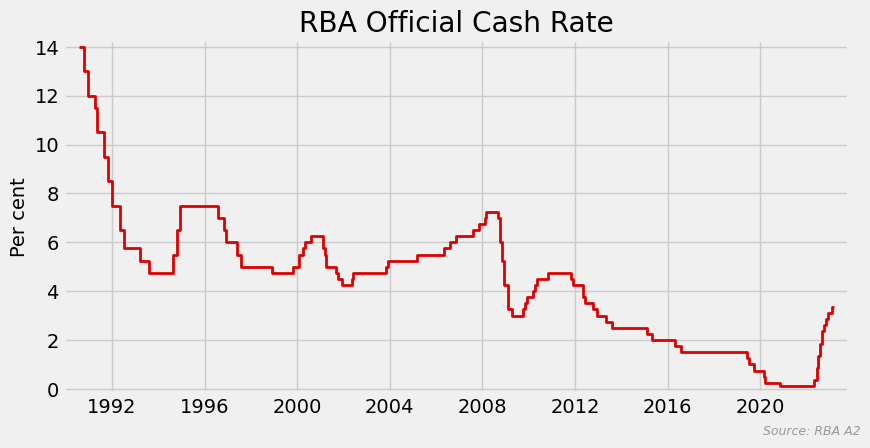

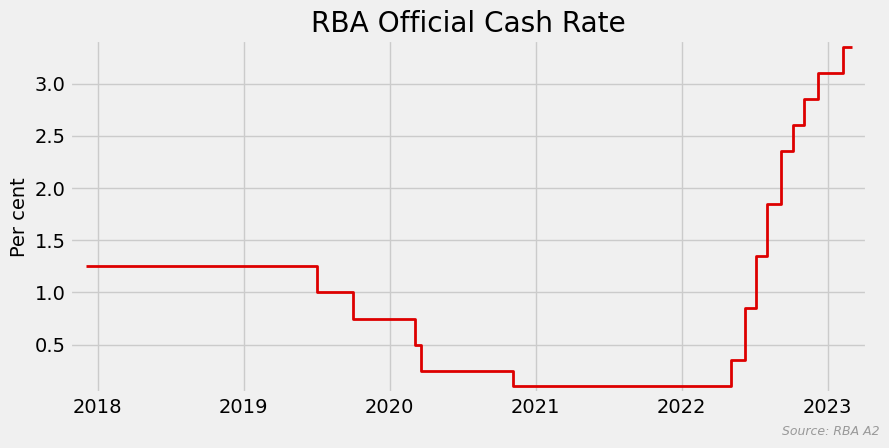

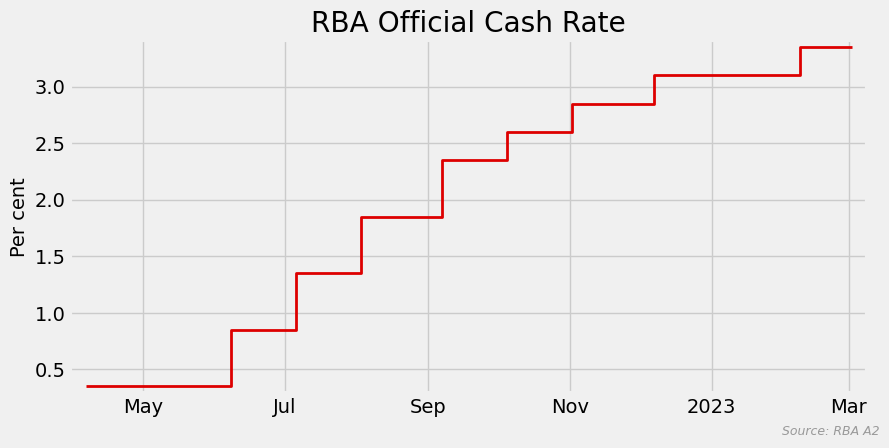

In [9]:
# extract the cash rate series
target = "New Cash Rate Target"
series_id = a2_meta[a2_meta.Title == target].index[0]
series = a2_data[series_id]

# remove some early target ranges
series = series[series.index >= pd.Timestamp("1990-08-02")].astype(float)

# update the series to today
if TODAY > series.index[-1]:
    last = series.iloc[-1]
    series[TODAY] = last
    series = series.sort_index()

# anticipate a rate rise/reduction
if ANTICIPATE:
    increase = pd.Series([series[-1] + IMCREASE_BY], index=[TOMORROW])
    series = pd.concat([series, increase]).sort_index()

# plot full series and recent
count = 0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = series if start is None else series[series.index >= start].copy()
    tag = "" if start is None else f"-recent{count}"
    if start is not None and start < data.index[0]:
        data[start] = data.iloc[0]
        data = data.sort_index()
    count += 1

    # plot
    ax = data.plot(drawstyle="steps-post", c="#dd0000", lw=2)
    ax.margins(0.025, 0.025)
    title = "RBA Official Cash Rate"
    finalise_plot(
        ax,
        title=title,
        ylabel="Per cent",
        tag=tag,
        rfooter=f"{SOURCE} A2",
        concise_dates=True,
        show=True,
    )

### Highlight the monetary policy tightening cycles

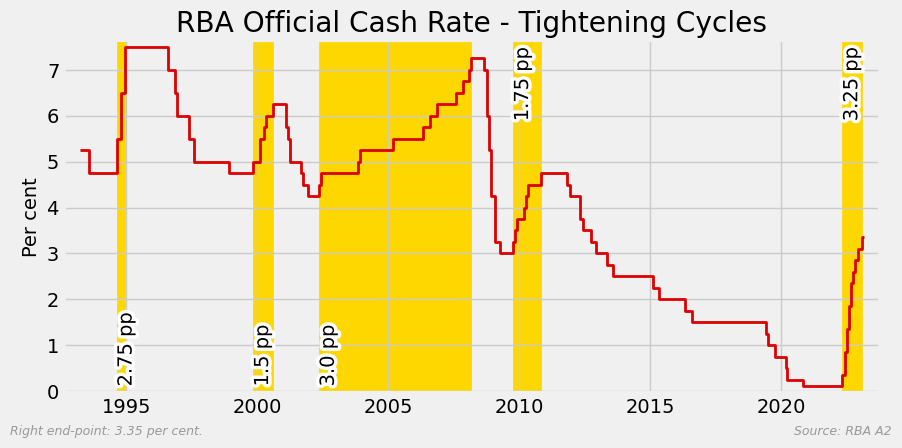

In [10]:
from_date = "1993-01-01"  # Start of RBA inflation-targeting approach
series_93 = series[series.index >= from_date]
series_93.index = series_93.index.to_period(freq="D")

ax = plot_series_highlighted(series_93)

finalise_plot(
    ax,
    title="RBA Official Cash Rate - Tightening Cycles",
    ylabel="Per cent",
    rfooter=f"{SOURCE} A2",
    lfooter=f"Right end-point: {series_93[-1]} per cent. ",
    show=True,
)

## Housing Loan Payments (E13)

In [29]:
e13 = rba_data_capture.get_data('Housing Loan Payments - E13')
e13_meta, e13_data = e13 if e13 is not None else (None, None)
e13_data = e13_data.to_period(freq='Q')

Using cached data for "Housing Loan Payments - E13"


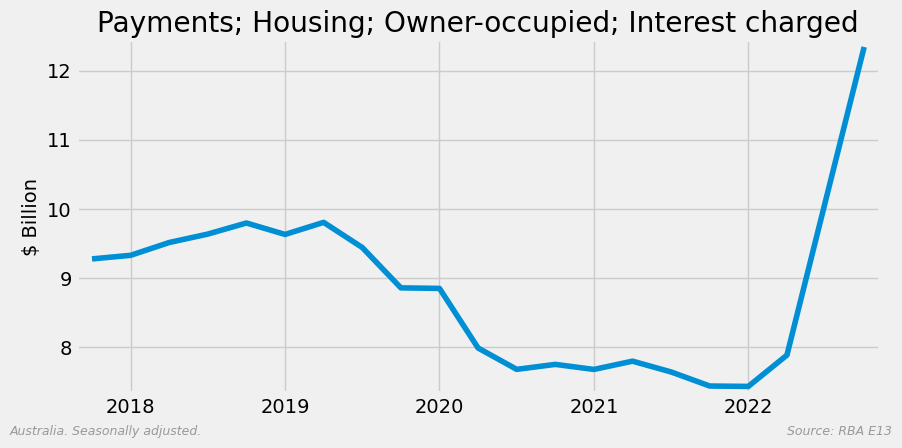

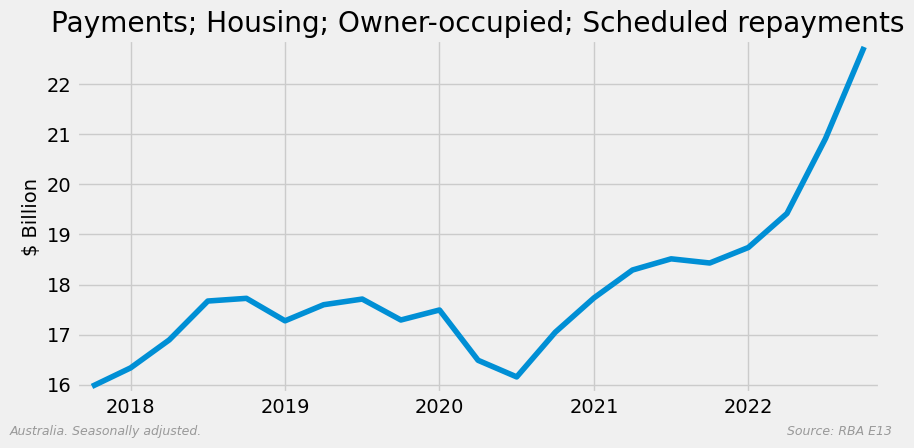

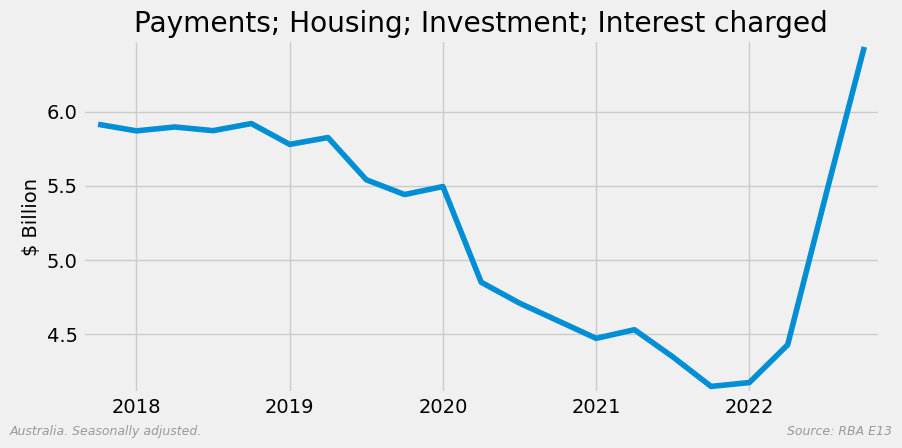

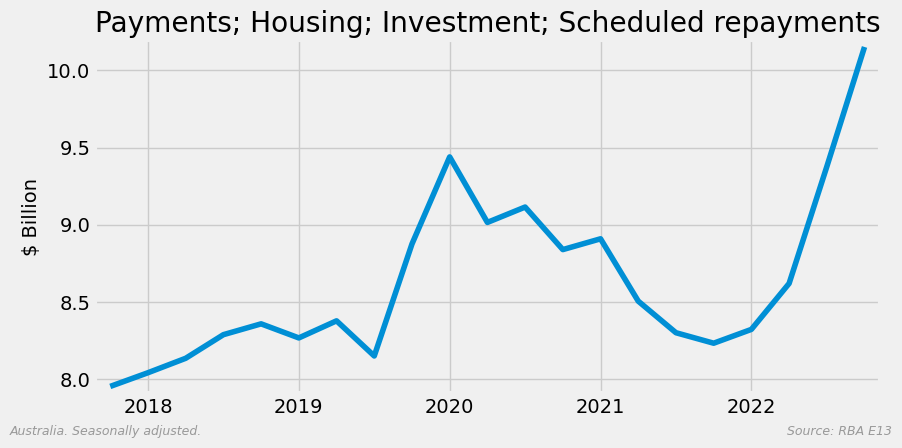

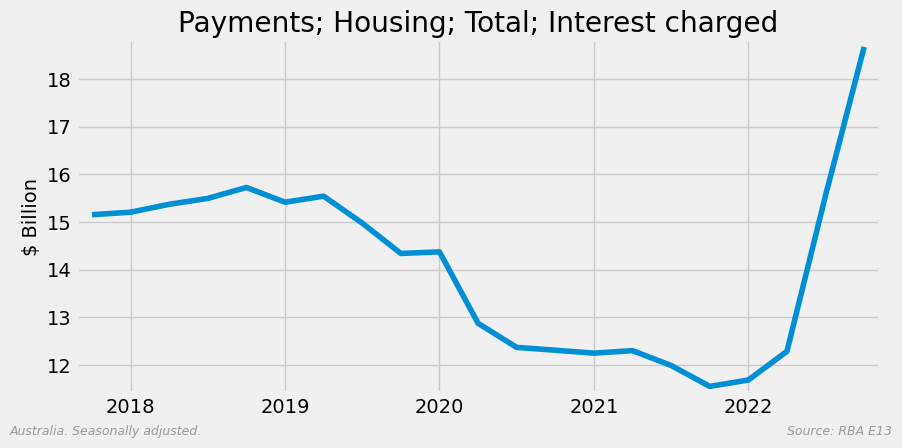

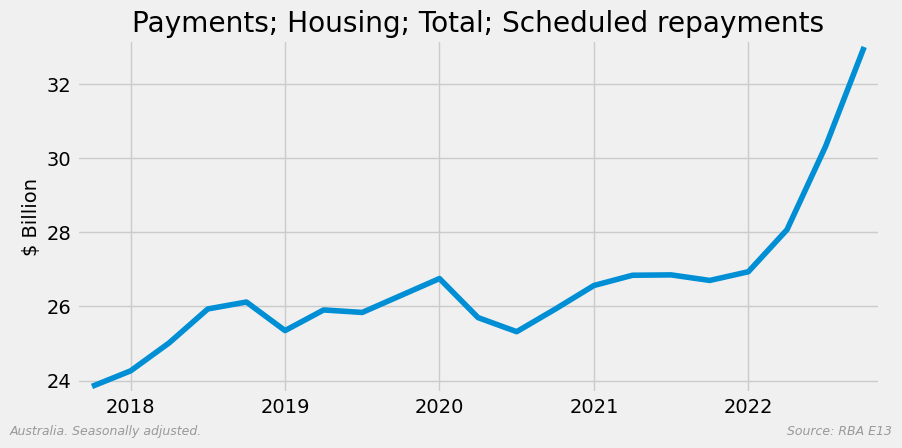

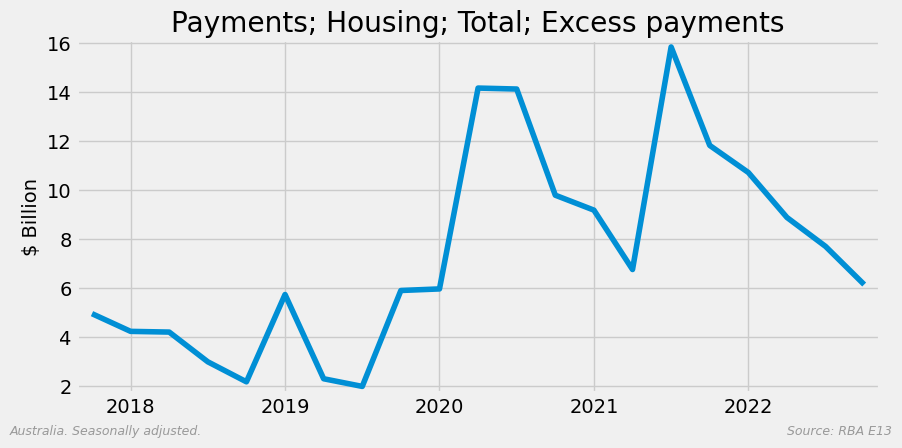

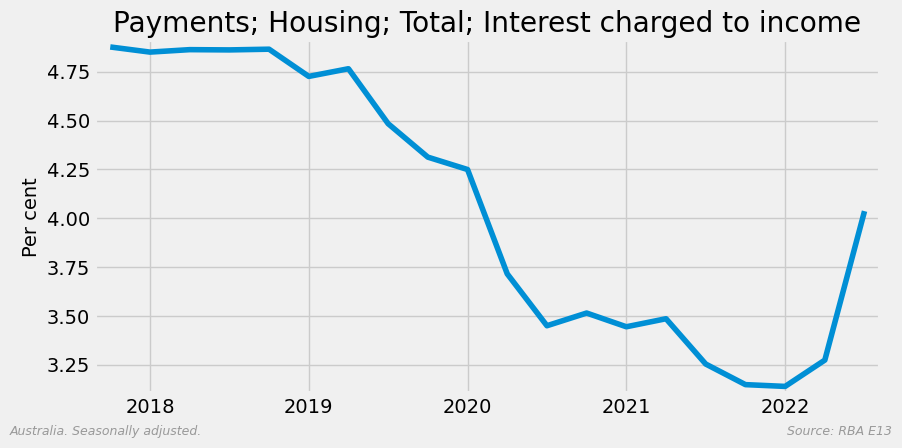

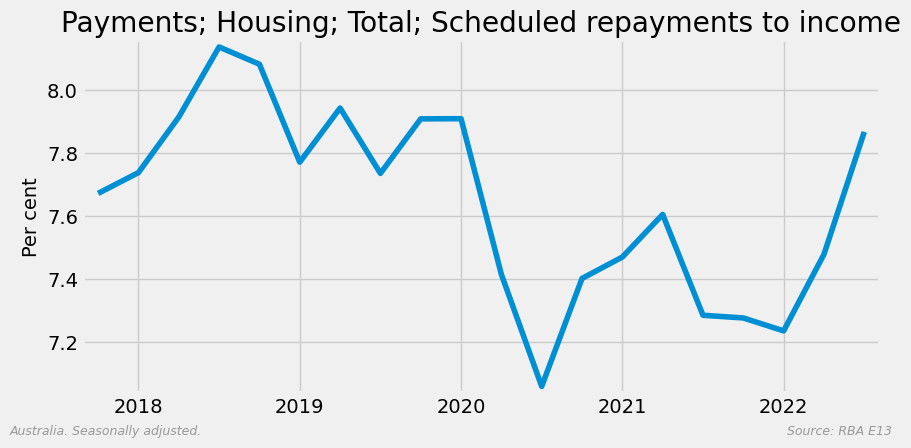

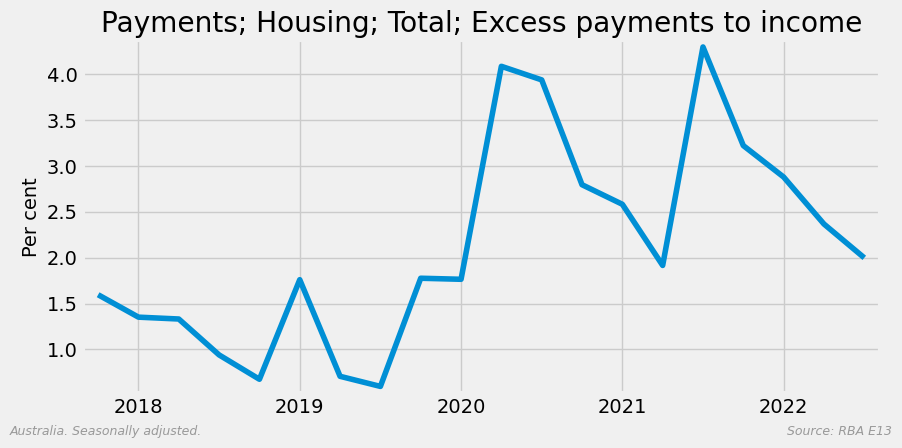

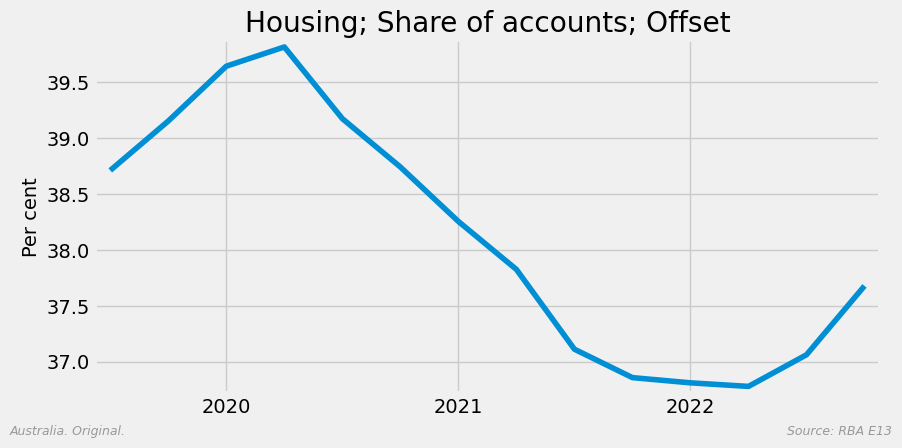

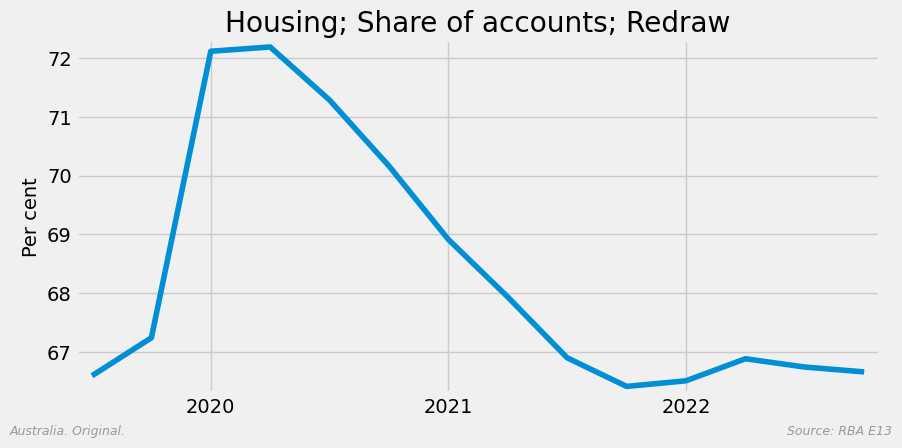

In [32]:
for index, row in e13_meta.iterrows():
    title = row['Title']
    unit = row['Units']
    id = row['Series ID']
    series_type = row['Type']
    series = e13_data[id].astype(float).dropna()
    series, unit  = recalibrate_series(series, unit)
    
    ax = series[series.index >= pd.Period(RECENT, freq='Q')].plot()
    finalise_plot(
        ax,
        title=title,
        ylabel=unit,
        rfooter=f"{SOURCE} E13",
        lfooter=f"Australia. {series_type}. ",
        show=True,
    )

## Key market interest rates (F1)

In [13]:
# get the dataset
_ = rba_data_capture.get_data("Interest Rates and Yields – Money Market – Daily – F1")
f1_meta, f1_data = _ if _ is not None else (None, None)

# just to see data currency ...
f1_data.loc[f1_data.index[-3:]]

Using cached data for "Interest Rates and Yields – Money Market – Daily – F1"


Series ID,FIRMMCRTD,FIRMMCCRT,FIRMMCRID,FIRMMCRIH,FIRMMCRIL,FIRMMCRIV,FIRMMCRIN,FIRMMCTRI,FIRMMBAB30D,FIRMMBAB90D,FIRMMBAB180D,FIRMMOIS1D,FIRMMOIS3D,FIRMMOIS6D,FIRMMTN1D,FIRMMTN3D,FIRMMTN6D
F1 INTEREST RATES AND YIELDS – MONEY MARKET,,,,,,,,,,,,,,,,,
2023-02-27,3.35,NaN,3.32,3.32,3.31,1217,11,126.633736,3.3592,3.55,3.905,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28,3.35,NaN,3.32,3.35,3.31,996,14,126.645254,3.3935,3.5728,3.9425,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.656774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


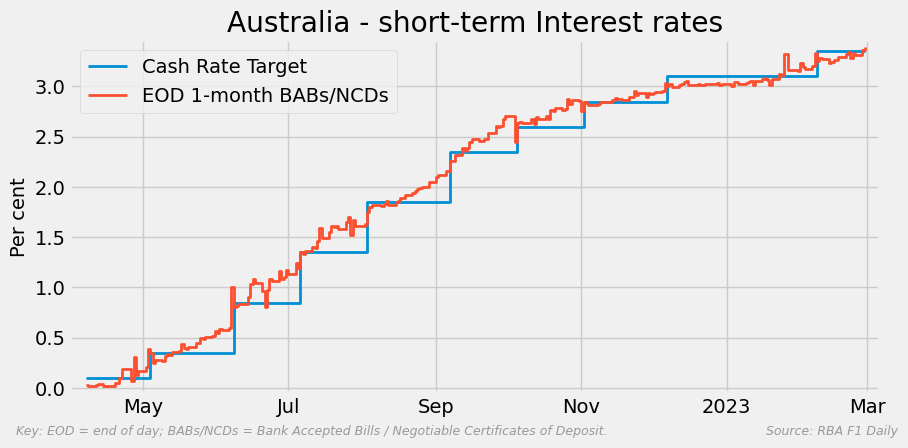

In [14]:
# get the specific data we want, for the very recent past
wanted = [
    "Cash Rate Target",
    #'Interbank Overnight Cash Rate',
    "EOD 1-month BABs/NCDs",
    # '1-month OIS', # discontinued December 2022
    # '1-month Treasury Note',
]
series_ids = [f1_meta[f1_meta.Title == x].index[0] for x in wanted]
plotable_data = (
    f1_data[series_ids]
    .pipe(lambda x: x[x.index >= V_RECENT])
    .rename({old: neu for old, neu in zip(series_ids, wanted)}, axis=1)
    .dropna(how="all", axis=1)
    .dropna(how="all", axis=0)
    .ffill()
)

# And plot
ax = plotable_data.plot(drawstyle="steps-post", lw=2)
ax.margins(0.025, 0.025)
title = "Australia - short-term Interest rates"
ax.legend(title=None, loc="best")

finalise_plot(
    ax,
    title=title,
    ylabel="Per cent",
    rfooter=f"{SOURCE} F1 Daily",
    lfooter="Key: EOD = end of day; "
    "BABs/NCDs = Bank Accepted Bills / Negotiable Certificates of Deposit.",
    concise_dates=True,
    show=True,
)

## Australian Government Bonds - daily rates (F2)

In [15]:
# get the dataset
_ = rba_data_capture.get_data("Capital Market Yields – Government Bonds – Daily – F2")
f2_meta, f2_data = _ if _ is not None else (None, None)
f2_data.loc[f2_data.index[-3:]]  # just to see data currency

Using cached data for "Capital Market Yields – Government Bonds – Daily – F2"


Series ID,FCMYGBAG2D,FCMYGBAG3D,FCMYGBAG5D,FCMYGBAG10D,FCMYGBAGID,FCMYGBNT3D,FCMYGBNT5D,FCMYGBNT10D
F2 CAPITAL MARKET YIELDS – GOVERNMENT BONDS,,,,,,,,
2023-02-27,3.645,3.63,3.7,3.875,1.825,3.99,4.095,4.55
2023-02-28,3.615,3.595,3.67,3.85,1.765,3.955,4.07,4.53
2023-03-01,3.53,3.505,3.585,3.785,1.735,3.87,3.985,4.465


In [16]:
# get the specific data we want
plotable = f2_meta[
    f2_meta.Title.str.contains("Australian") & f2_meta.Title.str.contains("year")
]
plotable_labels = plotable.Title.str.replace("Australian Government ", "")
plotable_data = f2_data[plotable_labels.index]
plotable_data.columns = plotable_labels

# plot full series and recent
count = 0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = (
        plotable_data
        if start is None
        else plotable_data[plotable_data.index >= start].copy()
    )
    tag = "" if start is None else f"-recent{count}"
    lw = 2 if start == V_RECENT else 1
    count += 1

    # plot
    ax = data.plot(drawstyle="steps-post", lw=lw)
    ax.margins(0.025, 0.025)
    title = "Capital Market Yields - Australian Government Bonds"

    # remove legend title
    # handles, labels = ax.get_legend_handles_labels()
    ax.legend(title=None, loc="best")

    # finalise
    finalise_plot(
        ax,
        title=title,
        ylabel="Per cent per annum",
        tag=tag,
        rfooter=f"{SOURCE} F2 Daily",
        concise_dates=True,
        # show=True,
    )

## Growth in credit aggregates (D1)

In [17]:
data_label = "Growth in Selected Financial Aggregates – D1"
_ = rba_data_capture.get_data(data_label)
d1_meta, d1_data = _ if _ is not None else (None, None)
print_last_date(d1_data)

Using cached data for "Growth in Selected Financial Aggregates – D1"
Data
Last date 2023-01-31


In [18]:
chart_set = [
    "Credit; Housing; Monthly growth",
    "Credit; Owner-occupier housing; Monthly growth",
    "Credit; Investor housing; Monthly growth",
    "Credit; Other personal; Monthly growth",
    "Credit; Business; Monthly growth",
    "Credit; Total; Monthly growth",
]

for label in chart_set:
    name = d1_meta[d1_meta.Title == label].index[0]
    type = d1_meta[d1_meta.Title == label].Type.iloc[0]
    series = d1_data[name]

    for start in None, RECENT:
        data = series if start is None else series[series.index >= start].copy()
        tag = "" if start is None else "-recent"
        lw = 2 if start else 1
        ax = data.plot(lw=lw, c="#dd0000")

        if data.min() < 0 and data.max() > 0:
            ax.axhline(lw=1, c="#999999")

        finalise_plot(
            ax,
            title=label,
            ylabel="Per cent",
            tag=tag,
            rfooter=f"{SOURCE} D1",
            lfooter=type,
            # show=True,
        )

## Money supply and the velocity of money (D3)

According to the Quantity Theory of Money:

$$ MV=PT $$

Where ($M$) is money supply, ($V$) is the velocity of circulation (the number of times 
money changes hands), ($P$) is the average price level, and ($T$) is the volume of transactions of goods and services. Of note: $PT$ is the same as nominal GDP. Therefore:

$$V=\frac{nGDP}{M}$$


### Money supply

In [19]:
# Get DataFrame for the M1 and M3 money supply
_ = rba_data_capture.get_data("Monetary Aggregates – D3")
d3_meta, d3_data = _ if _ is not None else (None, None)
print_last_date(d3_data)

Using cached data for "Monetary Aggregates – D3"
Last date 2023-01-31


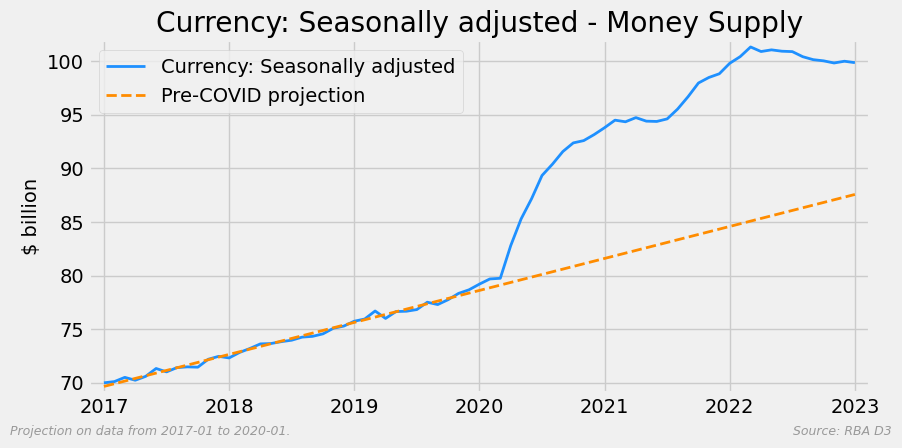

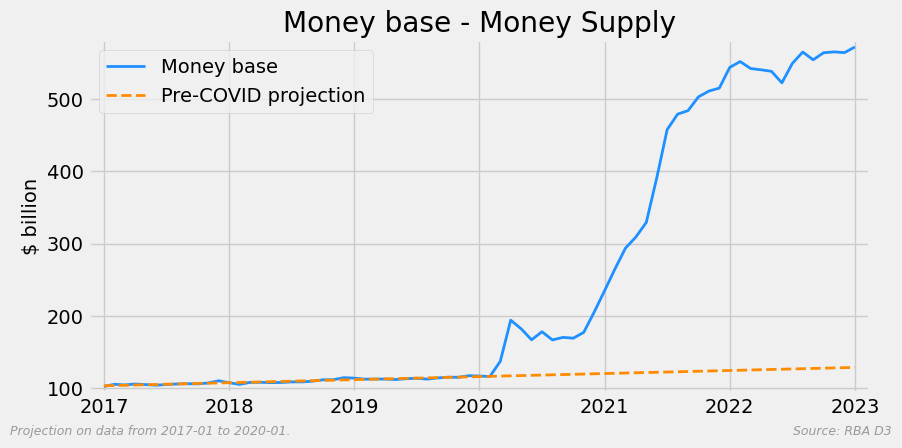

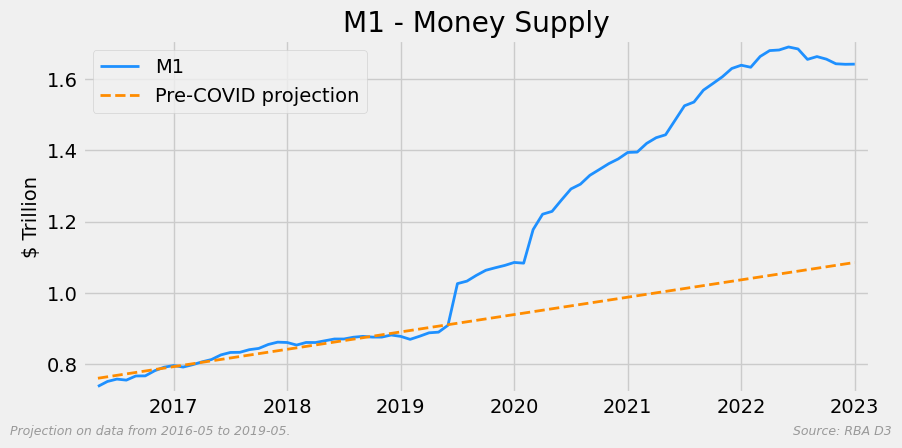

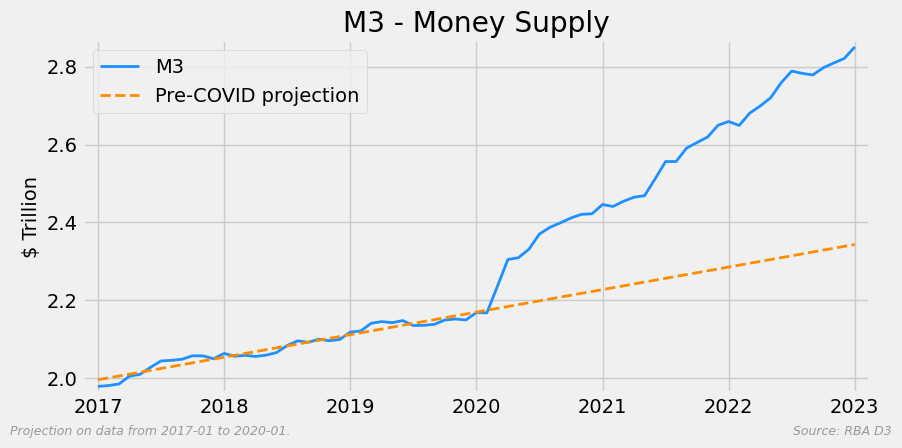

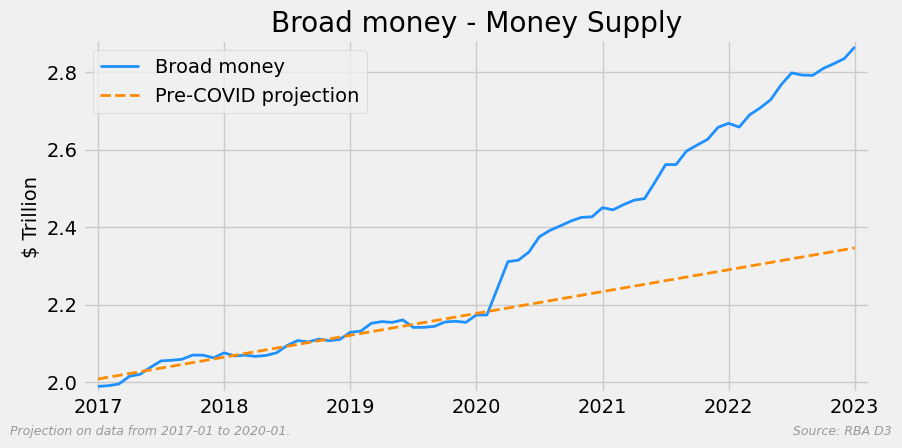

In [20]:
# plot Money Supply
to_get = ["Currency: Seasonally adjusted", "Money base", "M1", "M3", "Broad money"]
gotten = {t: d3_data[d3_meta[d3_meta.Title == t].index[0]] for t in to_get}
m_units = {t: d3_meta[d3_meta["Title"] == t].Units[0] for t in to_get}

for title, series in gotten.items():
    series = series.dropna().astype(float)
    series, m_unit = recalibrate_series(series, m_units[title])
    series.name = title
    chart_title = f"{title} - Money Supply"

    aux_kwargs = {}
    aux_kwargs["start_r"], aux_kwargs["end_r"] = (
        ("2016-05-01", "2019-05-01") if title == "M1" else ("2017-01-01", "2020-01-01")
    )
    plot_covid_recovery(
        series.to_period(freq="M"),
        **aux_kwargs,
        title=chart_title,
        tag="COVID",
        ylabel=m_unit,
        rfooter=f"{SOURCE} D3",
        # zero_y=True,
        show=True,
    )

    for start in None, TEN_YEARS:
        plotable = series if start is None else series[series.index >= start]
        tag = "" if start is None else f"recent"

        fig, ax = plt.subplots()
        ax.plot(plotable.index, plotable, lw=2)
        finalise_plot(
            ax,
            title=chart_title,
            ylabel=m_unit,
            tag=tag,
            rfooter=f"{SOURCE} D3",
            concise_dates=True,
            dont_close=True,
            # show=True,
        )

        ax.set_yscale("log")
        finalise_plot(
            ax,
            title=chart_title,
            ylabel=f"{m_unit} (log scale)",
            tag=f"{tag}-log",
            rfooter=f"{SOURCE} D3",
            concise_dates=True,
            # show=True,
        )

        # Note: matplotlib will only let you show either
        #       the linear or log charts, but not both.

### Nominal GDP

In [21]:
# get nominal GDP from the ABS National Accounts
catalogue_id = "5206"
abs_dict = get_ABS_meta_and_data(catalogue_id)
source, _, META_DATA = get_fs_constants(catalogue_id)
meta = abs_dict[META_DATA]

table = "3"  # GDP expenditure in current prices
data = abs_dict[table]

series_type = "Seasonally Adjusted"
data_item = "GROSS DOMESTIC PRODUCT ;"
selected = meta[
    (meta.Table == table)
    & (meta["Series Type"] == series_type)
    & meta["Data Item Description"].str.contains(data_item)
]
assert len(selected) == 1
units = selected.Unit.iloc[0]
series_id = selected["Series ID"].iloc[0]
yearly_nom_gdp = data[series_id].rolling(4).sum().dropna()  # sum to annual nominal GDP
yearly_nom_gdp, units = recalibrate_series(yearly_nom_gdp, units)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


### Velocity of money

In [22]:
# still to do

## Watermark

In [23]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Mar 02 2023 08:31:15

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

pandas    : 1.5.3
matplotlib: 3.7.0

Watermark: 2.3.1



In [24]:
print("Done")

Done
